In [1]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Folgore

In [3]:
# Load the training dataset
train_data = pd.read_csv("C:/Users/user/Documents/Bayes/ARP/ARP Topic/Codes/Codes/folgore_train_data.csv", encoding='ISO-8859-1')
# Load the prediction dataset 
prediction_data = pd.read_csv("C:/Users/user/Documents/Bayes/ARP/ARP Topic/Codes/Codes/folgore_test_data.csv", encoding='ISO-8859-1')

In [4]:
def preprocess_text(text):
    # Replace NaN values with empty strings
    text = str(text) if pd.notnull(text) else ''
    # Remove special characters and formatting using regular expressions
    text = re.sub(r'\n', ' ', text)  # Replace newlines with spaces
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Remove special characters except spaces
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    filtered_tokens = [word for word in tokens if word.lower() not in stopwords.words('english')]
    
    # Process the filtered text with spaCy for POS tagging
    doc = nlp(" ".join(filtered_tokens))
    
    # Create a list of token information (word/POS_tag/POS)
    processed_tokens = [f"{token.text}/{token.tag_}/{token.pos_}" for token in doc]
    
    # Join the processed tokens back into a sentence
    processed_text = " ".join(processed_tokens)
    
    return processed_text

# Apply the preprocessing function to the 'Comment' column of your train dataset
train_data['Processed_comment'] = train_data['Comment'].apply(preprocess_text)

# Apply the preprocessing function to the 'Comment' column of your test dataset
prediction_data['Processed_comment'] = prediction_data['Comment'].apply(preprocess_text)

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Author             140 non-null    object
 1   Date               140 non-null    object
 2   Comment            140 non-null    object
 3   Age_Group          141 non-null    int64 
 4   Processed_comment  141 non-null    object
dtypes: int64(1), object(4)
memory usage: 5.6+ KB


In [6]:
# Remove rows with NaN values
train_data = train_data.dropna()

# Reset the index after removing rows
train_data.reset_index(drop=True, inplace=True)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Author             140 non-null    object
 1   Date               140 non-null    object
 2   Comment            140 non-null    object
 3   Age_Group          140 non-null    int64 
 4   Processed_comment  140 non-null    object
dtypes: int64(1), object(4)
memory usage: 5.6+ KB


## Naive Bayes Model

In [8]:
# Convert the training text data to a numerical representation using CountVectorizer
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_data['Processed_comment'])  # Use 'Processed_comment' with a lowercase 'c'
y_train = train_data['Age_Group']

# Create and train a Multinomial Naive Bayes classifier
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Save the vectorizer object and trained classifier to files
with open('vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)
with open('naive_bayes_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

# Load the saved vectorizer and trained model for prediction
with open('vectorizer.pkl', 'rb') as vectorizer_file:
    loaded_vectorizer = pickle.load(vectorizer_file)
with open('naive_bayes_model.pkl', 'rb') as model_file:
    loaded_clf = pickle.load(model_file)

# Convert the prediction text data to the same numerical representation
X_pred = loaded_vectorizer.transform(prediction_data['Processed_comment'])

# Predict age groups on the prediction dataset
predicted_ages = loaded_clf.predict(X_pred)

# Add the predicted ages to the prediction dataset
prediction_data['predicted_age'] = predicted_ages

# Save the prediction results to a new CSV file
prediction_data.to_csv('Folgore_naive_bayes_predictions.csv', index=False)

In [9]:
# Perform cross-validation and get cross-validated accuracy scores
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')

# Print the accuracy scores for each fold and the mean accuracy
print("Cross-validated accuracy scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validated accuracy scores: [0.28571429 0.35714286 0.32142857 0.25       0.21428571]
Mean accuracy: 0.2857142857142857


In [11]:
# Load the prediction results with predicted_age column
prediction_data = pd.read_csv("C:/Users/user/Documents/Bayes/ARP/ARP Topic/Codes/Codes/Folgore_naive_bayes_predictions.csv", encoding='utf-8')

In [12]:
age_group_counts = prediction_data['predicted_age'].value_counts()
print("Age Group Counts:")
print(age_group_counts)

Age Group Counts:
10    20
30    19
20     7
40     1
Name: predicted_age, dtype: int64


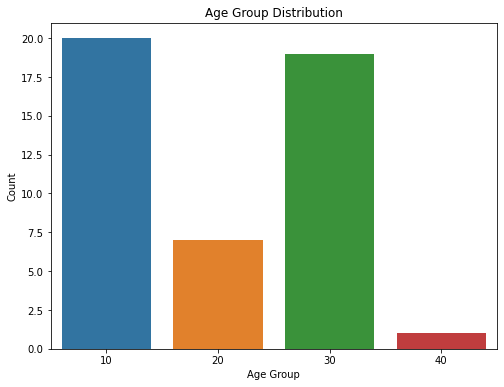

In [13]:
# Create a bar plot using seaborn
plt.figure(figsize=(8, 6))
sns.countplot(x='predicted_age', data=prediction_data)
plt.title("Age Group Distribution")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()

## TD-IDF With Naive Bayes

In [31]:
# Vectorize the comments using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['Processed_comment'])

# Train a Multinomial Naive Bayes classifier on the entire dataset
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tfidf, train_data['Age_Group'])

# Vectorize the comments in the prediction dataset using the same TF-IDF vectorizer
X_pred_tfidf = tfidf_vectorizer.transform(prediction_data['Processed_comment'])

# Predict age groups on the prediction dataset
predicted_ages = naive_bayes_classifier.predict(X_pred_tfidf)

# Add the predicted ages to the prediction dataset
prediction_data['predicted_age'] = predicted_ages

# Save the prediction results to a new CSV file
prediction_data.to_csv('Folgore_TDIDF_predicted_ages.csv', index=False)

In [32]:
# Calculate the cross-validation accuracy of the classifier
cross_val_scores = cross_val_score(naive_bayes_classifier, X_train_tfidf, train_data['Age_Group'], cv=5)
print("Average cross-validation accuracy:", np.mean(cross_val_scores))

Average cross-validation accuracy: 0.2857142857142857


In [33]:
# Evaluate the classifier on the training data
y_pred = clf.predict(X_train)
print("Training accuracy:", accuracy_score(y_train, y_pred))
print(classification_report(y_train, y_pred))

Training accuracy: 0.5642857142857143
              precision    recall  f1-score   support

          10       0.41      1.00      0.58        42
          20       1.00      0.19      0.32        31
          30       0.96      0.71      0.82        38
          40       1.00      0.14      0.24        29

    accuracy                           0.56       140
   macro avg       0.84      0.51      0.49       140
weighted avg       0.81      0.56      0.52       140



The cross-validation accuracy of 0.2857 is lower than the training accuracy of 0.5643, which suggests that the model is overfitting the training data.

In [25]:
prediction_data = pd.read_csv("C:/Users/user/Documents/Bayes/ARP/ARP Topic/Codes/Codes/Folgore_TDIDF_predicted_ages.csv", encoding='utf-8')

In [26]:
age_group_counts = prediction_data['predicted_age'].value_counts()
print("Age Group Counts:")
print(age_group_counts)

Age Group Counts:
10    43
30     4
Name: predicted_age, dtype: int64


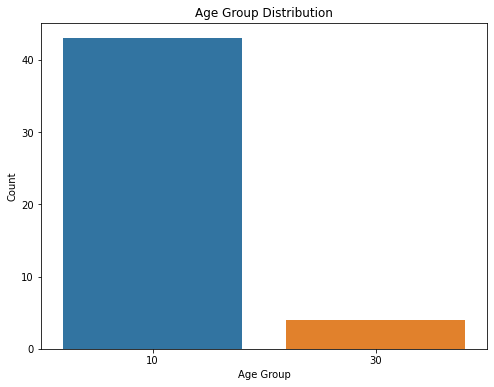

In [27]:
# Create a bar plot using seaborn
plt.figure(figsize=(8, 6))
sns.countplot(x='predicted_age', data=prediction_data)
plt.title("Age Group Distribution")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()

## Logistic Regression

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Author             140 non-null    object
 1   Date               140 non-null    object
 2   Comment            140 non-null    object
 3   Age_Group          140 non-null    int64 
 4   Processed_comment  140 non-null    object
dtypes: int64(1), object(4)
memory usage: 5.6+ KB


In [18]:
prediction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Author             47 non-null     object
 1   Date               47 non-null     object
 2   Comment            47 non-null     object
 3   Processed_comment  47 non-null     object
 4   predicted_age      47 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 2.0+ KB


In [19]:
# Convert the text data to a numerical representation using TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data['Processed_comment'])
X_pred = vectorizer.transform(prediction_data['Processed_comment'])

# Train a Logistic Regression classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, train_data['Age_Group'])

# Predict the age groups for the prediction data
predicted_ages = clf.predict(X_pred)

# Add the predicted age groups to the prediction data
prediction_data['predicted_age'] = predicted_ages

# Save the prediction results to a new CSV file
prediction_data.to_csv('Folgore_LR_age_classification', index=False)

In [20]:
# Calculate the cross-validation accuracy of the classifier
cross_val_scores = cross_val_score(clf, X_train, train_data['Age_Group'], cv=5)

# Print the average cross-validation accuracy
print("Average cross-validation accuracy:", np.mean(cross_val_scores))

Average cross-validation accuracy: 0.21428571428571427


## Logistic Regression - N-gram Vectorization

In [21]:
# Convert the training text data to a numerical representation using CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')
X_train = vectorizer.fit_transform(train_data['Processed_comment'])
y_train = train_data['Age_Group']

# Create and train a Logistic Regression classifier
clf = LogisticRegression(max_iter=1000, C=1.0, penalty='l2', solver='liblinear')
clf.fit(X_train, y_train)

# Convert the testing text data to the same numerical representation
X_pred = vectorizer.transform(prediction_data['Processed_comment'])

# Predict age groups on the testing dataset
predicted_ages = clf.predict(X_pred)

In [22]:
# Calculate the cross-validation accuracy of the classifier
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Average cross-validation accuracy:", np.mean(cross_val_scores))

Average cross-validation accuracy: 0.24285714285714288
